# Analyze SoHappy output files - Significances and timing

In [1]:
import gammapy
gammapy.__version__

'0.18.2'

In [2]:
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import setup
from setup import col_n, col_s, col_b, dtpop
from pop_plot import col_size, sig_legend, sig_plot_cumulative
import init as init

from utilities import MyLabel, single_legend, stamp

plt.style.use('seaborn-talk') # Make the labels readable
#plt.style.use('seaborn-poster') # Make the labels readable - bug with normal x marker !!!

## Read data - create the total population

In [3]:
# Open data, get population
nyears, file = init.create_csv(debug=False)
(grb, gn0, gs0, gn, gs, gb) = init.get_data(file, debug=False)

# Effective det_level
eff_lvl = init.get_eff_lvl(grb)

import pandas as pd
fullpop = pd.concat([gn0,gs0,gb],axis=0)
len(fullpop)

filetag = file.parent.name

# <font color="#FF0000">SIGNIFICANCES</font>
Could go in "find best grb" notebook

# Time to get a 5 sigma  detection

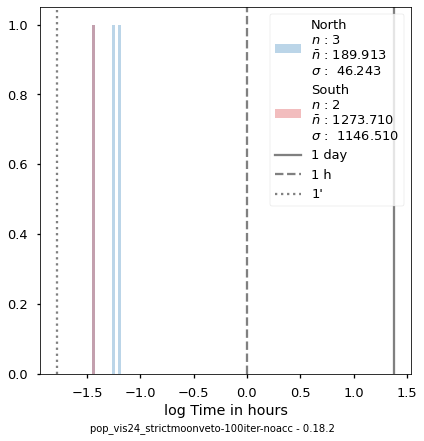

In [4]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
logx = True
nbin=10
n, bins, _ = ax1.hist(np.log10(gn[gn.d5s>eff_lvl].t5s/3600),
                      bins=nbin,color=col_n,alpha=0.3,label=MyLabel(gn[gn.d5s>eff_lvl].t5s,"North"))
n, bins, _ = ax1.hist(np.log10(gs[gs.d5s>eff_lvl].t5s/3600),
                               bins=bins,color=col_s,alpha=0.3,label=MyLabel(gs[gs.d5s>eff_lvl].t5s,"South"))
ax1.set_xlabel("log Time in hours")
ax1.axvline(np.log10(24),ls="-",color="grey",label="1 day")
ax1.axvline(np.log10(1),ls="--",color="grey",label="1 h")
ax1.axvline(np.log10(1/60),ls=":",color="grey",label="1'")

ax1.legend()
stamp(filetag,axis=fig,where="bottom")
plt.tight_layout()

### GRB with max siginificance obtained after one day

In [5]:
sigmx_min = 5
tmin = 24*3600
print(" Events above ",sigmx_min," (meanvalue), ",tmin/3600," h after the trigger")

for g,txt in zip([gn, gs, gb, fullpop],["North","South","Both","All"]):
    mask = g.sigmx>sigmx_min
    late_list = g[mask][g[mask].tmx>tmin]
    
    print(" {:5s} {:4d}"":".format(txt,len(late_list)))
    
    for s, t, sigma, d5s in zip(late_list.name,late_list.tmx, late_list.sigmx, late_list.d5s):
        print("{:10s}: t={:10.2f} sig={:10.2f} d5s={:5.2f}".format(s,t,sigma,d5s),end="")
        if d5s >= eff_lvl:
            print(" ***")
        elif sigma >= 3: 
            print(" *")
            
        else: print()
    # late_list.name.values.flatten()

 Events above  5  (meanvalue),  24.0  h after the trigger
 North    9:
Event148  : t= 148213.12 sig=      5.30 d5s=51.00 *
Event382  : t= 160523.06 sig=      5.10 d5s=42.00 *
Event392  : t= 134358.22 sig=      5.10 d5s=47.00 *
Event422  : t= 105690.50 sig=      5.40 d5s=43.00 *
Event441  : t= 111575.60 sig=      6.00 d5s=71.00 *
Event532  : t= 113084.64 sig=      5.20 d5s=44.00 *
Event573  : t= 113504.50 sig=      5.30 d5s=45.00 *
Event644  : t= 136120.50 sig=      5.30 d5s=51.00 *
Event718  : t= 123945.82 sig=      5.10 d5s=42.00 *
 South    6:
Event374  : t= 124364.88 sig=      5.30 d5s=40.00 *
Event441  : t= 159273.80 sig=      5.50 d5s=63.00 *
Event636  : t= 122054.89 sig=      5.10 d5s=45.00 *
Event781  : t= 105507.98 sig=      5.50 d5s=47.00 *
Event783  : t= 125096.97 sig=      5.30 d5s=45.00 *
Event949  : t= 119553.98 sig=      5.30 d5s=44.00 *
 Both    41:
Event20   : t= 137495.89 sig=      5.60 d5s=51.00 *
Event56   : t= 144886.70 sig=      5.40 d5s=45.00 *
Event57   : t= 1099

## Max. Significance distributions
The following plot shows that "Both" has better performance (sigma) than N and S separately

In [6]:
def plot_sigmax(g,ax=None,logx=True,bins=25,tag="",weight=1,xmax=None,**kwargs):
    """
    Plot the max siginificance dsitribution for one population
    """
    
    if (ax==None): fig,ax = plt.subplots()
        
    if (xmax != None): mask = g.sigmx < xmax
    else:              mask= (np.ones(len(g),dtype=bool)) & (g.sigmx!= -1)
        
    if logx:
        mask = (g.sigmx>0) & (mask) 
        x = np.log10(g[mask].sigmx)
        
        ax.set_title("Positive values only")
        ax.set_xlabel("$log_{10}(\sigma_{max})$")   
        ax.axvline(x=np.log10(3),color="tab:orange",ls=":",label="$3\sigma$")
        ax.axvline(x=np.log10(5),color="tab:green",ls=":",label="$5\sigma$") 
    else:
        x = g[mask].sigmx
        ax.set_xlabel("$\sigma_{max}$")
        ax.axvline(x=3.,color="tab:orange",ls=":",label="$3\sigma$")
        ax.axvline(x=5,color="tab:green",ls=":"  ,label="$5\sigma$")   
        
    n, bins,_ = ax.hist(x, bins=bins, label=MyLabel(x,tag,stat="med"),weights=np.ones(len(x))*weight,**kwargs) 
    
    single_legend(ax)
    
    return (ax, bins)

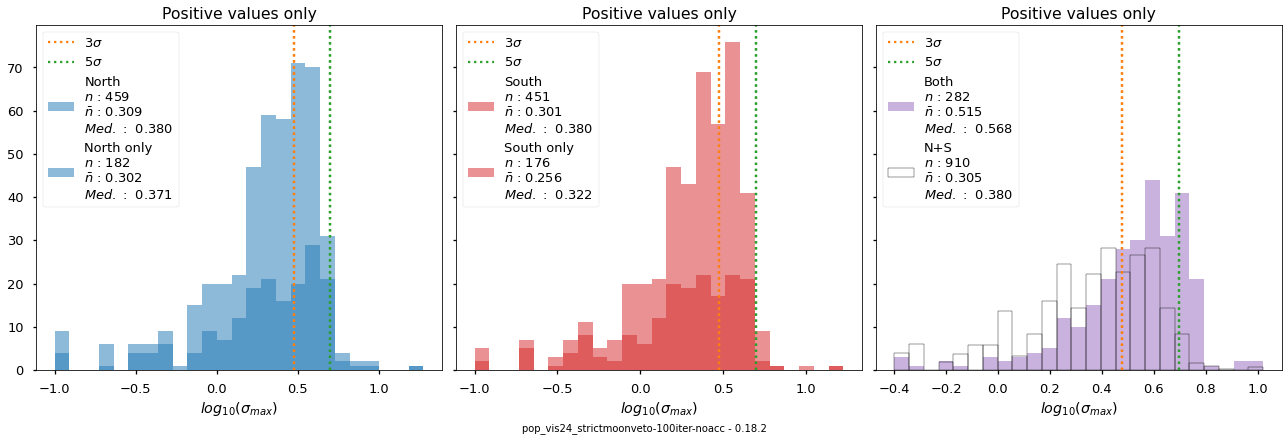

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3,figsize=(18,6),sharey=True)
logx = True
nbin=25
ax, bins = plot_sigmax(gn,tag="North",ax=ax1,bins=nbin,logx=logx,color=col_n,alpha=0.5)
plot_sigmax(gn0,tag="North only",ax=ax1,logx=logx,bins=bins,color=col_n,alpha=0.5)

ax, bins = plot_sigmax(gs,tag="South",ax=ax2,bins=nbin,logx=logx,color=col_s,alpha=0.5)
plot_sigmax(gs0,tag="South only",ax=ax,logx=logx,bins=bins,color=col_s,alpha=0.5)

ax, bins = plot_sigmax(gb,tag="Both",
                       logx=logx,color=col_b,ax=ax3,bins=nbin,alpha=0.5)
#plot_sigmax(pd.concat([gn0,gs0],axis=0),tag="N+S",logx=logx,facecolor="none",edgecolor="black",ax=ax3,bins=bins,alpha=1)
import pandas as pd
gtot= pd.concat([gn,gs],axis=0)
plot_sigmax(gtot,tag="N+S",
            logx=logx,facecolor="none",edgecolor="black",ax=ax3,bins=bins,alpha=1,weight=len(gb)/len(gtot))

# ax1.set_yscale("log")
# ax2.set_yscale("log")
# ax3.set_yscale("log")
stamp(filetag,axis=fig,where="bottom")
plt.tight_layout()

## Highest sigma values

In [8]:
siglist = [-0.5, 3, 5, 10, 20, 50, 100, 200]
poplist = [gn,gn0,gs,gs0,gb]
taglist = ["North","N only","South","S only","Both"]
duration = 10 # in years

In [9]:
# Mean sigmax value of events above 5 sigma at 90%CL
import itertools
for pop, tag in zip(poplist, taglist):
    print(tag)
    mask = pop.d5s>=eff_lvl
    glist = pop[mask]
    for sig, name in zip(glist.sigmx,glist["name"]):
        print(" - ",name," :",sig)
#     for g in pop:
#         print(g)
#         if g.d5s >= eff_lvl:
#             print(g["name]"],g.sigmx)

North
 -  Event283  : 9.5
 -  Event758  : 9.6
 -  Event945  : 18.8
N only
 -  Event283  : 9.5
 -  Event945  : 18.8
South
 -  Event275  : 16.8
 -  Event964  : 10.6
S only
 -  Event275  : 16.8
Both
 -  Event441  : 8.3
 -  Event758  : 9.7
 -  Event874  : 8.6
 -  Event964  : 10.5


In [11]:
print(" Detection rate with mean sigmax above sig for ",duration," years")
print(60*"-")

print("{:>10s}".format("Sig min"),end="")
for tag in taglist:
    print("{:>8s}".format(tag),end="")
print("{:>8s}".format("Tot"))
print(60*"-")

for sig in siglist:
    print("{:>10.1f}".format(sig),end="")
    ntot = len(gn0[gn0.sigmx>=sig]) + len(gs0[gs0.sigmx>=sig]) + len(gb[gb.sigmx>=sig])
    for p  in poplist:
        n = len(p[p.sigmx>=sig])
        print("{:>8.2f}".format(duration*n/dtpop),end="")
    print("{:>8.2f}".format(duration*ntot/dtpop))

print(60*"-")

 Detection rate with mean sigmax above sig for  10  years
------------------------------------------------------------
   Sig min   North  N only   South  S only    Both     Tot
------------------------------------------------------------
      -0.5  108.41   44.32  105.91   41.82   64.09  150.23
       3.0   40.23   16.59   36.59   12.95   43.18   72.73
       5.0    4.09    2.73    2.73    0.91   11.36   15.00
      10.0    0.23    0.23    0.45    0.23    0.23    0.68
      20.0    0.00    0.00    0.00    0.00    0.00    0.00
      50.0    0.00    0.00    0.00    0.00    0.00    0.00
     100.0    0.00    0.00    0.00    0.00    0.00    0.00
     200.0    0.00    0.00    0.00    0.00    0.00    0.00
------------------------------------------------------------


In [12]:
def high_sigma(gpop,ax=None,inset=True, sigmin= 5, sig2show=100, tag="", show=True, weight=1, **kwargs):
    """
    Check highest value of sigmax
    """

    #n,bins,_ = ax.hist(gpop.sigmx[gpop.sigmx>=sigmin],label=tag, **kwargs)
    var = gpop.sigmx[gpop.sigmx>=sigmin]
    weights = np.ones(len(var))*weight
    n,bins,_ = ax.hist(var,label=MyLabel(var*weights,tag,stat=None), weights = weights,**kwargs)
    #ax.set_yscale("log")
    ax.set_xlabel("$\sigma_{{max}} \geq {}$".format(sigmin))
    ax.set_ylabel("Event rate")
    #ax.set_title("Negative significances excluded")   
    # Inset in log
    if (inset):
        axx = inset_axes(ax, width="75%", height=1.2,loc="upper right")
        nxx,binsxx,_ = axx.hist(np.log10(gpop[gpop.sigmx>0].sigmx),
                           bins=25,color="grey",edgecolor="black", alpha=0.5)
        axx.axvline(np.log10(3),ls=":",color="red",lw="2",label="$3\sigma$")
        axx.axvline(np.log10(5),color="red",lw="2",label="$5\sigma$")
        axx.set_xlabel("Log $\sigma_{max}$")
        axx.legend()
        
        ax.legend(loc="upper left")
    else:
        ax.legend()
       

    # Outliers
    if show:
        outlier=zip(gpop[gpop.sigmx>sig2show].name,gpop[gpop.sigmx>sig2show].sigmx)
        i=1
        for g in outlier:
            y = (0+ (1.5*i + 0.1))*weight
            ax.text(x=g[1],y=y,s=g[0][5:],rotation=45)
            i+=1
    return ax, bins

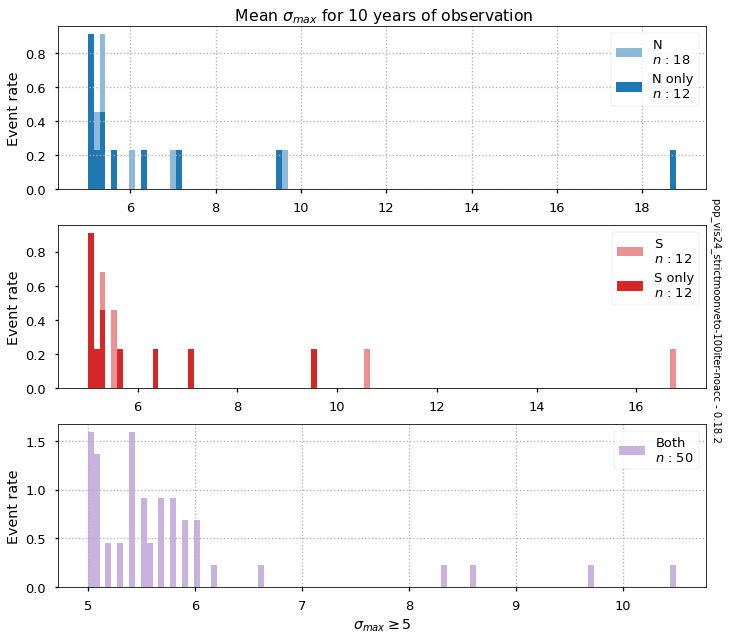

In [13]:
fig,ax = plt.subplots(nrows=3, ncols=1,figsize=(10,9))
nbin = 100
weight = 1/(44/duration)
sigmin = 5

ax0, bins = high_sigma(gn, sigmin=sigmin,
                       bins = nbin, color=col_n,ax=ax[0],
                       tag="N", alpha=0.5, weight=weight, inset=False)
high_sigma(gn0,  sigmin=sigmin,
           bins = bins, color=col_n,ax=ax0,tag="N only",show=False, weight=weight,inset=False)
ax0.set_xlabel(None)
ax0.set_title(" Mean $\sigma_{max}$ for "+str(duration)+" years of observation")
ax0.grid("both",ls=":")
# ax0.axhline(weight)
ax0, bins = high_sigma(gs, sigmin=sigmin,
                       bins = nbin, color=col_s,ax=ax[1],tag="S", alpha=0.5, weight=weight,inset=False)
high_sigma(gn0, sigmin=sigmin,
           bins = bins, color=col_s,ax=ax0,tag="S only",show=False, weight=weight,inset=False)
ax0.set_xlabel(None)

ax0, bins = high_sigma(gb, sigmin=sigmin,
                       bins=nbin, color=col_b,ax=ax[2],tag="Both", alpha=0.5,weight=weight, inset=False)
ax0.grid("both",ls=":")
stamp(filetag,axis=fig)

plt.tight_layout()

## Statistics at high sigma

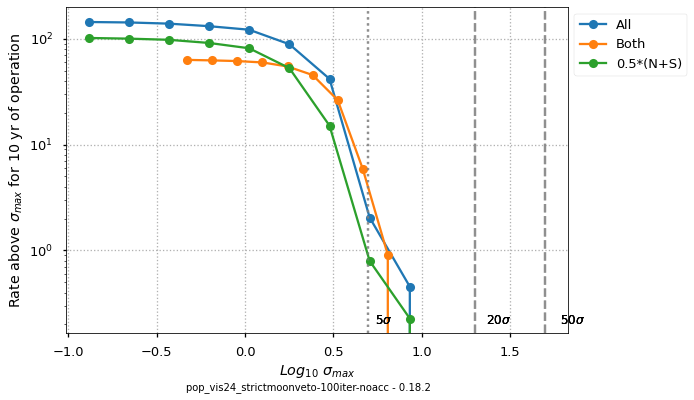

In [14]:
nbin=10
cumulative = False
import pandas as pd
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
first= True
# for g, tag, w in zip([fullpop, gb, pd.concat([gn0,gs0],axis=0),pd.concat([gn,gs],axis=0)],
#                   ["All", "Both", "Only N+ Only S", "0.5*(N+S)"],
#                 [1, 1, 1, 0.5]):
for g, tag, w in zip([fullpop, gb,pd.concat([gn,gs],axis=0)],
                  ["All", "Both", "0.5*(N+S)"],
                [1, 1, 0.5]):
    mask = g.sigmx > 0
    var = np.log10(g[mask].sigmx)
    
    if not first: nbin = bins
    n, bins = np.histogram(var, bins = nbin, weights=w*np.ones(len(var)))
    ncum = np.cumsum(n)
    ax.plot(bins[:-1] + 0.5*(bins[1:]-bins[:-1]),(max(ncum)-ncum)*10/dtpop,alpha=1,
            marker="o",label=tag)

#     print(ncum)

    single_legend(ax,bbox_to_anchor=[1.0,1.0])
    ax.grid("both",ls=":")
    ax.axvline(np.log10(50),color="grey",alpha=0.5,ls="--")
    ax.text(np.log10(50)*1.05,0.2,"$50\sigma$",size=12)
    
    ax.axvline(np.log10(20),color="grey",alpha=0.5, ls="--")
    ax.text(np.log10(20)*1.05,0.2,"$20\sigma$",size=12)
            
    ax.axvline(np.log10(5),color="grey",alpha=0.5,ls=":")
    ax.text(np.log10(5)*1.05,0.2,"$5\sigma$",size=12)

    ax.set_xlabel("$Log_{10}$ $\sigma_{max}$")
    ax.set_ylabel("Rate above $\sigma_{max}$ for 10 yr of operation")
    ax.set_yscale("log")
stamp(filetag, axis=fig, where="bottom")

In [15]:
siglist = [-0.5, 3, 5, 10, 20, 50, 100, 200]
poplist = [gn, gn0, gs, gs0, gb, fullpop]
taglist = ["North", "N only", "South", "S only", "Both", "All"]

print("{:>8s} ".format("sigmin"),end="")

for tag in taglist:
    print("{:>8s} ".format(tag),end="")
print()
    
for sigmin in siglist:
    print("{:8.1f} ".format(sigmin),end="")
    for g in poplist:
        print("{:8.1f} ".format(len(g[g.sigmx>=sigmin])*10/dtpop),end="")
    print()

  sigmin    North   N only    South   S only     Both      All 
    -0.5    108.4     44.3    105.9     41.8     64.1    150.2 
     3.0     40.2     16.6     36.6     13.0     43.2     72.7 
     5.0      4.1      2.7      2.7      0.9     11.4     15.0 
    10.0      0.2      0.2      0.5      0.2      0.2      0.7 
    20.0      0.0      0.0      0.0      0.0      0.0      0.0 
    50.0      0.0      0.0      0.0      0.0      0.0      0.0 
   100.0      0.0      0.0      0.0      0.0      0.0      0.0 
   200.0      0.0      0.0      0.0      0.0      0.0      0.0 


# <font color="#FF0000">TIMING</font>

## 3s, 5s and sigmax time distribution
Don't forget the confidence level !!!

In [16]:
def sig_plot(varlist, masks=None, tags=None, xlabel="", yscale="log", binw=1, tobs=[], **kwargs):
    
    if masks == None: 
        masks = np.ones(len(varlist)).astype(bool)
        
    # Define one hour binning from the min and max
    tmax = int(max([max(v[m]) for v,m in zip(varlist,masks)]))
    bins=range(0, tmax+ 1, binw)
    print(" Max time :",tmax, " bins:",bins)
    
    fig, ax = plt.subplots(nrows=len(varlist), ncols=1,figsize=(12,3.5*len(varlist)),sharex=True)
    
    first = True
    for ax0, tag, var, mask in zip(ax,tags,varlist,masks):
        
        n, bins,_ = ax0.hist(var[mask],bins=bins,label=MyLabel(var[mask],label=tag+" (Burst)",stat="med"),**kwargs)
        if len(tobs) != 0:
            ax0.hist(var[mask]-tobs[mask],bins=bins,label=MyLabel(var[mask]-tobs[mask],label=tag+" (Start)",stat="med"),**kwargs)
        ax0.set_yscale(yscale)
        # ax0.set_title(tag)
        
        ax0.legend()
        ax0.grid(which='both')
        minor_ticks= bins
        ax0.set_xticks(minor_ticks, minor=True)
        
        ax0.grid(which="major",ls=":")
        ax0.grid(which="minor",ls=":",alpha=0.5)
        ax0.set_ylabel("$h^{-1}$") 

        ax0.set_xlabel(xlabel) # Last one
        
        axx = inset_axes(ax0, width="50%", height=1.2,loc="upper center")
        nxx,binsxx,_ = axx.hist(var[mask][var[mask]<1]*60,bins=range(0,60,1),alpha=0.5)
        axx.axvline(107/60,ls=":",label=" Swift + LST delays")
        axx.set_xlabel("$\Delta t$ (min)")
        axx.set_ylabel("$min^{-1}$") 
        axx.legend()
        
    stamp(filetag,axis=fig)    
    plt.tight_layout()

 Max time : 44  bins: range(0, 45)


C:\Users\stolar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


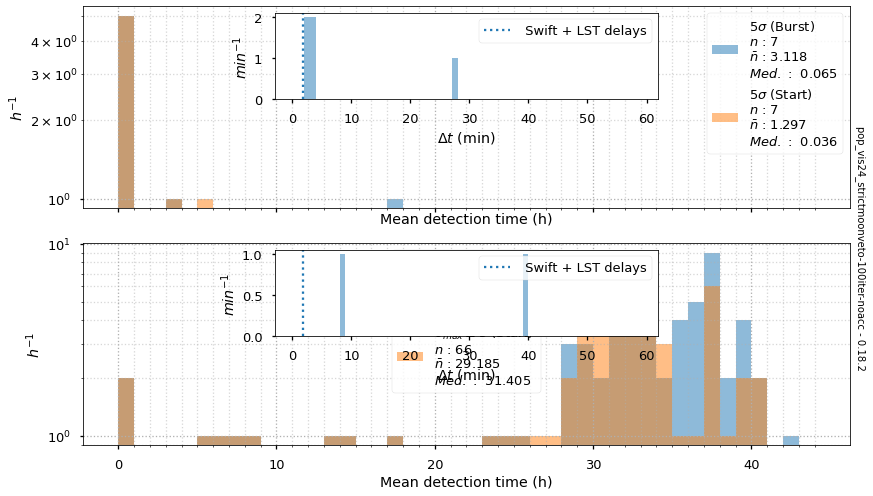

In [17]:
# Don't forget the confidence level !!!!
# varlist  = [fullpop.t3s/3600, fullpop.t5s/3600, fullpop.tmx/3600] # Go to hours
# masklist = [(fullpop.d3s>eff_lvl), (fullpop.d5s>eff_lvl), (fullpop.tmx>=0) & (fullpop.sigmx>=5)]
# taglist = ["$3 \sigma$","$5\sigma$","$\sigma_{max} \geq 5$"]

varlist  = [fullpop.t5s/3600, fullpop.tmx/3600] # Go to hours
masklist = [(fullpop.d5s>eff_lvl), (fullpop.tmx>=0) & (fullpop.sigmx>=5)]
taglist = ["$5\sigma$","$\sigma_{max} \geq 5$"]
sig_plot(varlist,masks=masklist,tags=taglist, xlabel="Mean detection time (h)",binw=1, tobs = fullpop.t1/3600,yscale="log",alpha=0.5)


C:\Users\stolar\Anaconda3\envs\gpy0.18.2\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


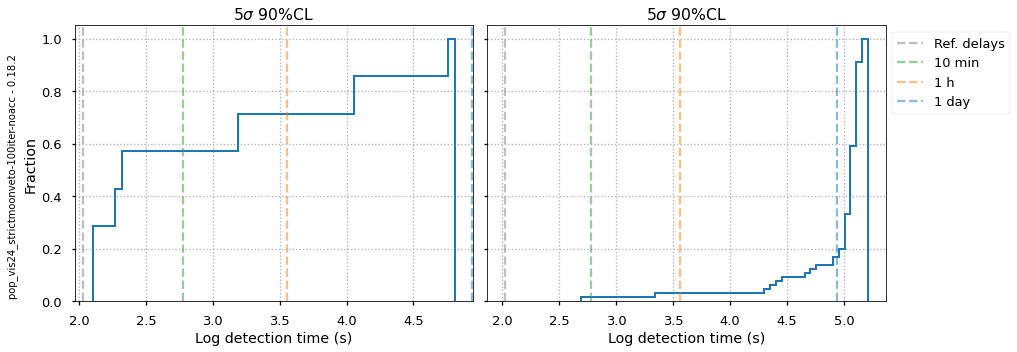

In [18]:
pop =fullpop
    
varlist  = [np.log10(pop.t5s), np.log10(pop.tmx)] # Go to hours
masklist = [(pop.d5s>eff_lvl), (pop.tmx>=0) & (fullpop.sigmx>=5)]

fig, ax = plt.subplots(ncols=len(varlist), nrows=1,figsize=(7*len(varlist), 5),sharey=True)

first = True
for ax0, var, mask in zip(ax,varlist,masklist):
    sig_plot_cumulative(var,mask=mask,title="$5\sigma$ 90%CL", 
                        ax=ax0, xlabel="Log detection time (s)")
    if first:
        ax0.set_ylabel("Fraction") 
        first = False
        
single_legend(ax0,bbox_to_anchor=[1,1])
stamp(filetag,axis=fig,where="left")
plt.tight_layout()

C:\Users\stolar\Anaconda3\envs\gpy0.18.2\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


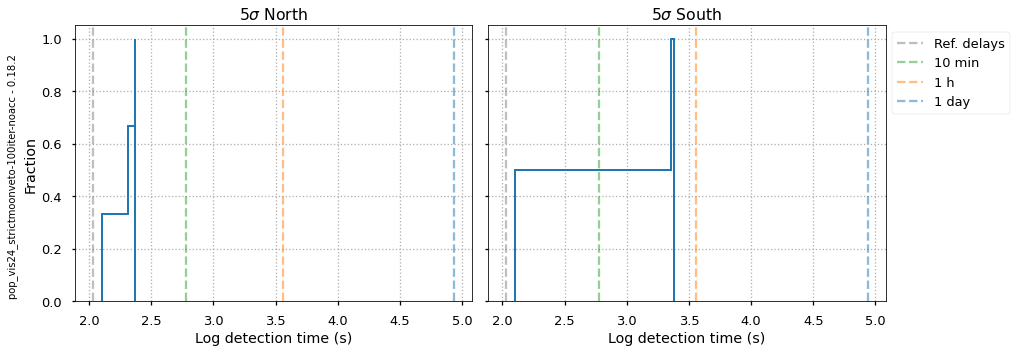

In [19]:
pop =fullpop
varlist  = [np.log10(gn.t5s), np.log10(gs.t5s)] # Go to hours
masklist = [(gn.d5s>eff_lvl), (gs.d5s>eff_lvl)]
taglist = ["$5\sigma$ North","$5\sigma$ South"]
fig, ax = plt.subplots(ncols=len(varlist), nrows=1,figsize=(7*len(varlist), 5),sharey=True)

first = True
for ax0, tag, var, mask in zip(ax,taglist,varlist,masklist):
    sig_plot_cumulative(var,mask=mask,title=tag, 
                        ax=ax0, xlabel="Log detection time (s)")
    if first:
        ax0.set_ylabel("Fraction") 
        first = False
        
single_legend(ax0,bbox_to_anchor=[1,1])
stamp(filetag,axis=fig,where="left")
plt.tight_layout()

In [20]:
## Time versus error on time
def sig2_plot(varlist1, varlist2, masklist, xlabel="", ylabel="", xscale="log", yscale="log", nbin=100, **kwargs):
    
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,6),sharey=True)
    taglist = ["$3 \sigma$","$5\sigma$","$\sigma_{max}$"]
    
    first=True
    for ax0, tag, var1, var2, mask in zip(ax,taglist,varlist1,varlist2, masklist):
        ax0.scatter(var1[mask], var2[mask],**kwargs)
        ax0.set_xscale(xscale)
        ax0.set_yscale(yscale)
        ax0.set_xlabel(xlabel)
        if first: 
            ax0.set_ylabel(ylabel) 
        else: 
            ax0.set_ylabel(None)
            first=False        
        ax0.set_title(tag)
        #ax0.legend()
        ax0.grid(ls=":")
        
    stamp(filetag,axis=fig)    
    plt.tight_layout()

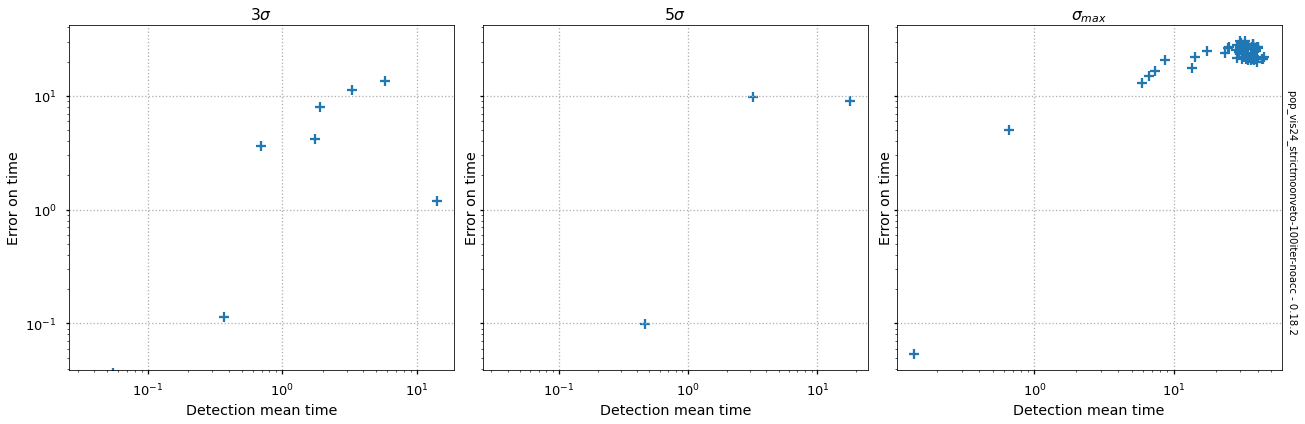

In [21]:
varlist1 = [fullpop.t3s/3600, fullpop.t5s/3600, fullpop.tmx/3600]
varlist2 = [fullpop.et3s/3600, fullpop.et5s/3600, fullpop.etmx/3600]
masklist = masklist = [(fullpop.d3s>eff_lvl), (fullpop.d5s>eff_lvl), (fullpop.tmx>=0) & (fullpop.sigmx>=5)]

sig2_plot(varlist1,varlist2,masklist,xlabel="Detection mean time",ylabel="Error on time",marker="+")
#sig2_plot(varlist1,varlist2,masklist,xlabel="Detection mean time",ylabel="Error on time",xscale="linear",yscale="linear",marker="+")

# <font color="#FF0000">SIGNIFICANCE versus TIMING</font>

## Raw plot

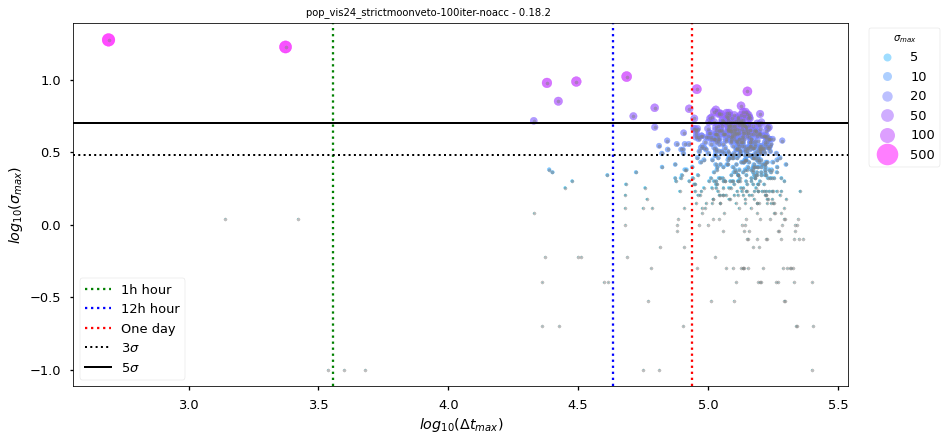

In [22]:
def plot_t_sigma(g,tag=""):
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12,6),sharex=True)

    mask = g.sigmx>0
    colors, sizes = col_size(g[mask].sigmx)
    ax.scatter(np.log10(g[mask].tmx),np.log10(g[mask].sigmx),marker="o",color=colors,alpha=0.7,s=sizes)
    ax.scatter(np.log10(g[mask].tmx),np.log10(g[mask].sigmx),marker="x",alpha=0.5,s=5,color="grey")

    ax.set_xlabel("$log_{10}(\Delta t_{max})$")
    ax.set_ylabel("$log_{10}(\sigma_{max})$")
    o1 = ax.axvline(x=np.log10(3600),ls=":",color="green",label="1h hour")
    o2 = ax.axvline(x=np.log10(12*3600),ls=":",color="blue",label="12h hour")
    o3 = ax.axvline(x=np.log10(24*3600),ls=":",color="red",label="One day")
    o4 = ax.axhline(np.log10(3),ls=":",color="black",lw="2",label="$3\sigma$")
    o5 = ax.axhline(np.log10(5),color="black",lw="2",label="$5\sigma$")
    
    ax.legend(loc="lower left")
    
    patches = sig_legend(ax)
    fig.legend(title="$\sigma_{max}$",handles=patches, bbox_to_anchor=(1.1, 0.98))
    stamp(filetag,axis=fig,where="top")    
    return
plot_t_sigma(fullpop,tag="All")
plt.tight_layout()

In [23]:
# Plot sigmax and errors
def sig_vs_time(pop,mask,ax=None,xscale="log",yscale="log",title=""):
    ax = plt.gca() if ax is None else ax
    ax.errorbar(pop[mask].tmx/3600,
                pop[mask].sigmx,
                xerr=pop[mask].etmx/3600,
                yerr=pop[mask].esigmx,
                ls="", marker="o",ecolor="tab:blue",color="red",alpha=0.5,
                label=MyLabel(pop[mask].sigmx,stat=None))
    # ax.axhline(y=3,ls=":",label="$3\sigma$",color="lightgrey")
    # ax.axhline(y=5,ls=":",label="$5\sigma$",color="lightgrey")
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlabel("Mean Time of max detection (h)")
    ax.set_ylabel("Mean max sigificance")
    ax.set_title(title)
    ax.legend()

In [24]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
sig_vs_time(fullpop,(fullpop.sigmx>=20),
            yscale="log",ax=ax1, title="$\sigma_{max} > 20$")
sig_vs_time(fullpop,(fullpop.sigmx>=5) & (fullpop.sigmx<20),
            xscale="linear",yscale="linear",ax=ax2,title="$5 < \sigma_{max} < 20$")
stamp(filetag,axis=fig)

ValueError: Data has no positive values, and therefore can not be log-scaled.

## Delay correlation for GRB seen on both sites
<font color="#FF0000">Warning</font>: works if accelaration was False, i.e. a results was obatined fro all sites (Abortion due to acceleration breaks the N/S symmetry)

In [ ]:
# Find N and S detection for all both detected GRB
# Get name of GRB detected on both sites and retrieve the independent N and S detections
t1_s = []
t1_n = []
t_s = []
t_n = []
sig_s = []
sig_n = []
sigmx = []
sigmin = 5

for name in gb.name:
    gsb = gs[gs.name==name] # This is the row
    gnb = gn[gn.name==name]
#     print(" ****", name,":")
#     print("   t1 N = ",gnb.t1.values)
#     print("   t1 S = ",gsb.t1.values)
    sig = gb[gb.name == name].sigmx.values[0]
    if sig>= sigmin:
        sigmx.append(gb[gb.name == name].sigmx.values[0]) 
        t1_s.append(gsb.t1.values[0]/3600)
        t1_n.append(gnb.t1.values[0]/3600)    
    t_s.append(gsb.t1.values[0]/3600)
    t_n.append(gnb.t1.values[0]/3600) 
    sig_s.append(gsb.sigmx.values[0]/3600)
    sig_n.append(gnb.sigmx.values[0]/3600)   
t1_s = np.array(t1_s)
t1_n = np.array(t1_n)
t_s = np.array(t_s)
t_n = np.array(t_n)
sig_s = np.array(sig_s)
sig_n = np.array(sig_n)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,7))
color, size = col_size(sigmx)
sc = ax.scatter(t1_n, t1_s,  alpha=0.5,c= color, s=size, label = MyLabel(t1_n,"$\sigma_{max}$"))
# for tn, ts, sig in zip(t1_n,t1_s, sigmx):
#     ax.text(tn,ts,str(sig))
ax.set_title("Seen on both sites - $\sigma_{max} \geq "+str(sigmin)+"$")
ax.set_xlabel("Mean detection time (h) - North")
ax.set_ylabel("Mean detection time (h) - South")
xmax = 26
ymax = 26
ax.set_xlim(xmax=26)
ax.set_ylim(ymax=26)

# ZOOM
xmin_z = 0
xmax_z = 2
ymin_z = 0
ymax_z = 5
ax.axvspan(xmin_z-1,xmax_z,ymin=ymin_z-1,ymax=(ymax_z+1)/ymax,color="grey",ls=":",alpha=0.5,lw=2,ec="black",fill=False)

axx = inset_axes(ax, width="30%", height=3,loc="upper right")
sc = axx.scatter(t1_n, t1_s,  alpha=0.5,c= color, s=size, label = MyLabel(t1_n,"$\sigma_{max}$"))
axx.set_xlim(xmax=xmax_z)
axx.set_ylim(ymax=ymax_z)

stamp(filetag, axis=fig,where="bottom")
patches = sig_legend(ax)
fig.legend(title="$\sigma_{max}$",handles=patches,bbox_to_anchor=(1.02, 0.88))

In [ ]:
nbin = 25
fig, ax = plt.subplots()
# n, bins, _ = ax.hist(t1_s-t1_n,label=MyLabel(t1_n),bins=nbin,alpha=0.5,color=col_n)
ax.scatter(t_s-t_n,(sig_s-sig_n)/sig_n,alpha=0.5,color=col_n,marker=".")
# ax.hist(t1_s,label=MyLabel(t1_s),bins=bins,alpha=0.5,color=col_s)
ax.set_xlabel("dt")
ax.set_ylabel("dsig")


In [ ]:
t1_n - t1_s